In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#IMDB Data (imdb)
imdb_title_basics_df = pd.read_csv('../zippedData/imdb.title.basics.csv.gz')

#The Numbers (tn)
tn_movie_budgets_df = pd.read_csv('../zippedData/tn.movie_budgets.csv.gz')

## IMDB Title_basics data

Let's clean the imdb_title_basics_df

In [3]:
# Set index to primary_title for merging later
imdb_title_index = imdb_title_basics_df.set_index('primary_title')
# Drop unused columns
imdb_title_index_dropped = imdb_title_index.drop(['tconst', 'original_title', 'start_year'], axis=1)
# Drop entries that have missing values (there are very few and we need all values for our analysis)
imdb_title_index_removedna = imdb_title_index_dropped.dropna(axis=0, how = 'any')
# Assign cleaned DataFrame to new variable
final_imdb_title_df = imdb_title_index_removedna

## tn_movie_budgets_df


In [4]:
# Stripping dollar signs from the series
tn_movie_budgets_df['production_budget'] = tn_movie_budgets_df['production_budget'].map(lambda x: x.lstrip('$'))
tn_movie_budgets_df['domestic_gross'] = tn_movie_budgets_df['domestic_gross'].map(lambda x: x.lstrip('$'))
tn_movie_budgets_df['worldwide_gross'] = tn_movie_budgets_df['worldwide_gross'].map(lambda x: x.lstrip('$'))
# Remove the commas from the series
tn_movie_budgets_df.loc[:, "production_budget":"worldwide_gross"] = tn_movie_budgets_df.loc[:, "production_budget":"worldwide_gross"].replace(",","", regex=True).astype('int64')
# Rename the columns
tn_movie_budgets_df.rename(columns = {'movie':"primary_title"}, inplace = True)
final_imdb_title_df.rename(columns = {'primary_title':"title"}, inplace = True)

C:\Users\camla\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


## Merging the data


In [5]:
# Perform inner merge
final_df = tn_movie_budgets_df.merge(final_imdb_title_df, on= 'primary_title', how= 'inner')
# Create a total_gross column for further understanding of the data
final_df["total_gross"] = final_df["domestic_gross"] + final_df["worldwide_gross"]

## Average Gross per Genre


In [6]:
# Stack the genres columns after removing the columns (must set expand=True so that it returns a DataFrame rather thana series)
# Count the total occurences of each genre
count = final_df['genres'].str.split(',', expand=True).stack().value_counts()
# Copy final_df to another variable
genres = final_df.copy()

In [7]:
# Split genres into columns
genres[['genre1', 'genre2', 'genre3']] = final_df['genres'].str.split(',', expand=True)
# Calculate profit per movie
genres['profit'] = genres['total_gross'] - genres['production_budget']
# genres

In [8]:
# Find total world_wide, domestic_ gross, and total_gross for each genre across all entries

# Worldwide
genre1_worldwide_gross = genres.groupby('genre1')['worldwide_gross'].sum()
genre2_worldwide_gross = genres.groupby('genre2')['worldwide_gross'].sum()
genre3_worldwide_gross = genres.groupby('genre3')['worldwide_gross'].sum()
# Domestic
genre1_domestic_gross = genres.groupby('genre1')['domestic_gross'].sum()
genre2_domestic_gross = genres.groupby('genre2')['domestic_gross'].sum()
genre3_domestic_gross = genres.groupby('genre3')['domestic_gross'].sum()
# Total
genre1_total_gross = genres.groupby('genre1')['total_gross'].sum()
genre2_total_gross = genres.groupby('genre2')['total_gross'].sum()
genre3_total_gross = genres.groupby('genre3')['total_gross'].sum()

# Add the calculated values and drop insignificant genres

# Worldwide
genre_total_worldwide_gross = genre1_worldwide_gross.add(genre2_worldwide_gross, fill_value=0).add(genre3_worldwide_gross, fill_value=0)
final_genre_worldwide_gross = genre_total_worldwide_gross.drop(['News', 'Reality-TV', 'Romance', 'Biography', 'Mystery', 'Sci-Fi', 'Family', 'Fantasy', 'Animation', 'History', 'Music', 'Sport', 'War', 'Musical', 'Western'])
# Domestic
genre_total_domestic_gross = genre1_domestic_gross.add(genre2_domestic_gross, fill_value=0).add(genre3_domestic_gross, fill_value=0)
final_genre_total_domestic_growth = genre_total_domestic_gross.drop(['News', 'Reality-TV', 'Romance', 'Biography', 'Mystery', 'Sci-Fi', 'Family', 'Fantasy', 'Animation', 'History', 'Music', 'Sport', 'War', 'Musical', 'Western'])
# Total
genre_total_gross = genre1_total_gross.add(genre2_total_gross, fill_value=0).add(genre3_total_gross, fill_value=0)
final_genre_total_gross = genre_total_gross.drop(['News', 'Reality-TV', 'Romance', 'Biography', 'Mystery', 'Sci-Fi', 'Family', 'Fantasy', 'Animation', 'History', 'Music', 'Sport', 'War', 'Musical', 'Western'])

In [9]:
#Concatenate series into a useable DataFrame, rename index
final_gross_df = pd.concat([final_genre_total_domestic_growth, final_genre_worldwide_gross, final_genre_total_gross], axis=1).reset_index()
final_gross_df_cleaned = final_gross_df.set_index('index')
final_gross_df_cleaned.index.name = 'Genre'

In [10]:
# Concatenate the count series to the final_gross_df_cleaned DataFrame to calculate averages
final_gross_avg = pd.concat([final_gross_df_cleaned, count], axis=1)
# Clean up DataFrame
final_gross_avg.rename(columns = {0:'count'}, inplace=True)
final_gross_avg.drop(['News', 'Reality-TV', 'Romance', 'Biography', 'Mystery', 'Sci-Fi', 'Family', 'Fantasy', 'Animation', 'History', 'Music', 'Sport', 'War', 'Musical', 'Western'], inplace=True)
# Calculate averages
final_gross_avg['domestic_avg'] = final_gross_avg['domestic_gross'] / final_gross_avg['count']
final_gross_avg['worldwide_avg'] = final_gross_avg['worldwide_gross'] / final_gross_avg['count']
final_gross_avg['total_avg'] = final_gross_avg['total_gross'] / final_gross_avg['count']
# Drop unneeded columns for easier plotting
final_gross_avg.drop(['domestic_gross', 'worldwide_gross', 'total_gross', 'count', 'total_avg'], axis=1, inplace=True)

## Visualizing Total Counts of Each Genre

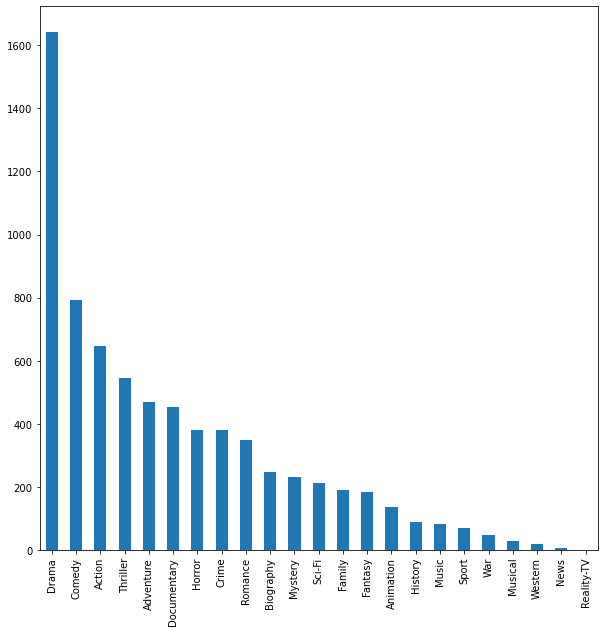

In [11]:
# Plot count of each genre to determine the top 8
count.plot(kind='bar', figsize=(10,10));

In [12]:
# Final total profit (Gross - Budget) for each genre
genre1_total_profit = genres.groupby('genre1')['profit'].sum()
genre2_total_profit = genres.groupby('genre2')['profit'].sum()
genre3_total_profit = genres.groupby('genre3')['profit'].sum()
# Sum up calculated values and drop insignificant genres
genre_overall_profit = genre1_total_profit.add(genre2_total_profit, fill_value=0).add(genre3_total_profit, fill_value=0)
final_genre_profit_df = genre_overall_profit.drop(['News', 'Reality-TV', 'Romance', 'Biography', 'Mystery', 'Sci-Fi', 'Family', 'Fantasy', 'Animation', 'History', 'Music', 'Sport', 'War', 'Musical', 'Western'])
# final_genre_profit_df

# Concatenate the two series(count and final_genre_profit_df) to create a DataFrame organized by index
merged = pd.concat([final_genre_profit_df, count], axis=1)
# Rename the column's
final_merged = merged.rename(columns={0:'count'})
# Calculate average profit
final_merged['average_profit'] = final_merged['profit'] / final_merged['count']
# Drop insignificant rows (insignificant due to low amount of entries)
averages = final_merged.drop(['News', 'Reality-TV', 'Romance', 'Biography', 'Mystery', 'Sci-Fi', 'Family', 'Fantasy', 'Animation', 'History', 'Music', 'Sport', 'War', 'Musical', 'Western'])
# Drop previously used catergories for easier plotting
averages_without_profit = averages.drop(['profit', 'count'], axis=1)

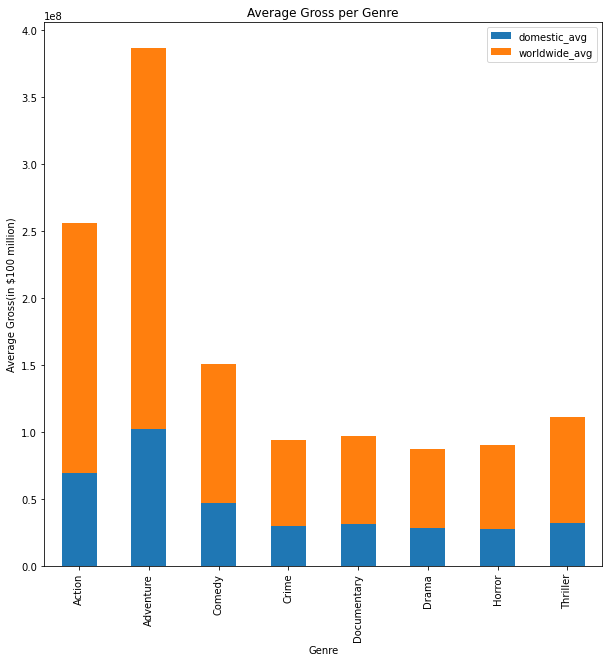

In [13]:
# Plot data
final_gross_avg.plot(kind='bar', stacked=True, figsize=(10,10))
plt.title('Average Gross per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Gross(in $100 million)');

## Average Profit per Genre


In [14]:
# Final total profit (Gross - Budget) for each genre
genre1_total_profit = genres.groupby('genre1')['profit'].sum()
genre2_total_profit = genres.groupby('genre2')['profit'].sum()
genre3_total_profit = genres.groupby('genre3')['profit'].sum()
# Sum up calculated values and drop insignificant genres
genre_overall_profit = genre1_total_profit.add(genre2_total_profit, fill_value=0).add(genre3_total_profit, fill_value=0)
final_genre_profit_df = genre_overall_profit.drop(['News', 'Reality-TV', 'Romance', 'Biography', 'Mystery', 'Sci-Fi', 'Family', 'Fantasy', 'Animation', 'History', 'Music', 'Sport', 'War', 'Musical', 'Western'])
# final_genre_profit_df

# Concatenate the two series(count and final_genre_profit_df) to create a DataFrame organized by index
merged = pd.concat([final_genre_profit_df, count], axis=1)
# Rename the column's
final_merged = merged.rename(columns={0:'count'})
# Calculate average profit
final_merged['average_profit'] = final_merged['profit'] / final_merged['count']
# Drop insignificant rows (insignificant due to low amount of entries)
averages = final_merged.drop(['News', 'Reality-TV', 'Romance', 'Biography', 'Mystery', 'Sci-Fi', 'Family', 'Fantasy', 'Animation', 'History', 'Music', 'Sport', 'War', 'Musical', 'Western'])
# Drop previously used catergories for easier plotting
averages_without_profit = averages.drop(['profit', 'count'], axis=1)

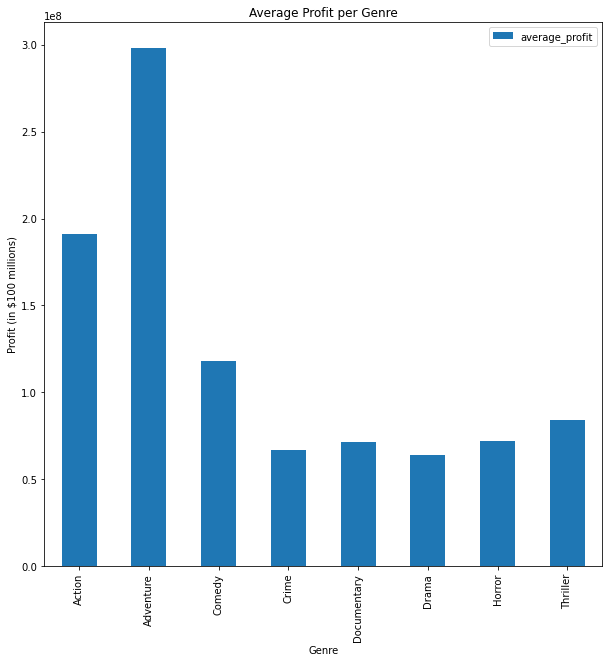

In [15]:
# Plot data
averages_without_profit.plot(kind='bar', figsize=(10,10))
plt.title('Average Profit per Genre')
plt.xlabel('Genre')
plt.ylabel('Profit (in $100 millions)');

## Analysis #2: What is the optimal movie runtime for each genre?

In [16]:
#Add total_gross column to the final_df
final_df["total_gross"] = final_df["domestic_gross"] + final_df["worldwide_gross"]
final_df["total_profit"] = final_df["total_gross"] - final_df["production_budget"]

In [17]:
## Copy final_df dataframe into genres dataframe
genres = final_df.copy()

## Separate genres column and create genre1, genre2, genre3 with respective value.
genres[['genre1', 'genre2', 'genre3']] = final_df['genres'].str.split(',', expand=True)
genres.head()

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,runtime_minutes,genres,total_gross,total_profit,genre1,genre2,genre3
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,93.0,Horror,3536852904,3111852904,Horror,None,None
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,136.0,"Action,Adventure,Fantasy",1286727750,876127750,Action,Adventure,Fantasy
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,113.0,"Action,Adventure,Sci-Fi",192524700,-157475300,Action,Adventure,Sci-Fi
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,141.0,"Action,Adventure,Sci-Fi",1862019831,1531419831,Action,Adventure,Sci-Fi
4,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,149.0,"Action,Adventure,Sci-Fi",2726949682,2426949682,Action,Adventure,Sci-Fi


In [18]:
## Remove unnecessary columns, and combine all the data from genre1, genre2 genre3 column into one single column.

genres_a = genres[["primary_title","production_budget","total_profit","runtime_minutes","genre1"]]
genres_a.columns = ["primary_title","production_budget","total_profit","runtime_minutes","genre1"]

genres_b = genres[["primary_title","production_budget","total_profit","runtime_minutes","genre2"]]
genres_b.columns = ["primary_title","production_budget","total_profit","runtime_minutes","genre1"]

genres_c = genres[["primary_title","production_budget","total_profit","runtime_minutes","genre3"]]
genres_c.columns = ["primary_title","production_budget","total_profit","runtime_minutes","genre1"]

In [19]:
## Create a new dataframe with cleaned up data. 
runtime_df = pd.concat([genres_a, genres_b, genres_c], axis=0)
## Change column name genre1 to genre
runtime_df = runtime_df.rename(columns = {"genre1" : "genre"})

In [20]:
## Remove all the rows where count of genre is less than 150. (data with less than 150 counts can be misleading)
genre_counts = runtime_df["genre"].value_counts()
to_remove = genre_counts[genre_counts < 351].index

## Set up a new dataframe to be used for optimal runtime data
## We are left with the data containing Top 8 Genres
runtime_df = runtime_df[~runtime_df.genre.isin(to_remove)]

In [21]:
## Find out minimum & maximum value in 
runtime_df["runtime_minutes"].describe()

## Set up runtime_minutes count dataframe to visualize abundancy of each runtime.
runtime_counts = runtime_df["runtime_minutes"].value_counts().reset_index()
runtime_counts.columns = ["runtime_minutes", "count"]

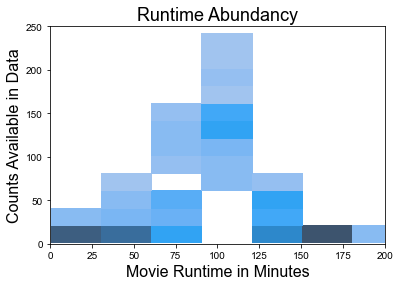

In [22]:
## Visualize Rutime Abundancy on our runtime_df dataframe.

## Create a histogram to visualize abundancy of movies' running time
ax = sns.histplot(x = runtime_counts["runtime_minutes"], y = runtime_counts["count"])

## Set Figure size and Colors
sns.set(rc={'figure.figsize':(22,15)})
sns.set_theme(style="whitegrid")

## Set title to labels and graph.
ax.set_title("Runtime Abundancy", size = 18)
ax.set_xlabel("Movie Runtime in Minutes", size = 16)
ax.set_ylabel("Counts Available in Data", size = 16)

## Set limits to x and y axis
ax.set(xlim = (0,200))
ax.set(ylim = (0,250));

## Save Image of this plot
plt.savefig('Runtime Abundancy Histogram')

In [23]:
## Set up a dataframe with the 10 indexes shown below.
for i, x in zip(runtime_df["runtime_minutes"], range(len(runtime_df["runtime_minutes"]) + 1)):
    if i < 50:
        runtime_df["runtime_minutes"].iloc[x] = "less than 50"
    elif i >= 50 and i < 70:
         runtime_df["runtime_minutes"].iloc[x] = "50 to 69"   
    elif i >= 70 and i < 80:
         runtime_df["runtime_minutes"].iloc[x] = "70 to 79"
    elif i >= 80 and i < 90:
         runtime_df["runtime_minutes"].iloc[x] = "80 to 89"
    elif i >= 90 and i < 100:
         runtime_df["runtime_minutes"].iloc[x] = "90 to 99"
    elif i >= 100 and i < 110:
        runtime_df["runtime_minutes"].iloc[x] = "100 to 109"
    elif i >= 110 and i < 120:
        runtime_df["runtime_minutes"].iloc[x] = "110 to 119"
    elif i >= 120 and i < 130:
        runtime_df["runtime_minutes"].iloc[x] = "120 to 129"
    elif i >= 130 and i <= 150:
        runtime_df["runtime_minutes"].iloc[x] = "130 to 150"
    else:
        runtime_df["runtime_minutes"].iloc[x] = "greater than 150"

C:\Users\camla\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [24]:
## Obtain % Profit data on the runtime_df dataframe in int type.
runtime_df["% Profit"] = (runtime_df["total_profit"] / runtime_df["production_budget"]) * 100
runtime_df["% Profit"] = runtime_df["% Profit"].astype(int)
runtime_df["Count"] = 1

In [25]:
## Group By Genre, Runtime_minuts then mean of % Profit
runtime_df_agg = pd.pivot_table(runtime_df, values = ["% Profit", "Count"], index = ["genre", "runtime_minutes"],
                                aggfunc= {"% Profit": np.mean,
                                          "Count": np.sum})

## Remove index to make it easier to work with.
runtime_df_agg = runtime_df_agg.reset_index()

## Remove all the rows where count is less than 10 which could be misleading.
runtime_df_agg = runtime_df_agg[runtime_df_agg['Count'] > 10]

In [26]:
## Group By Genre, Runtime_minuts then median of % Profit
runtime_df_agg_med = pd.pivot_table(runtime_df, values = ["% Profit", "Count"], index = ["genre", "runtime_minutes"],
                                aggfunc= {"% Profit": np.median,
                                          "Count": np.sum})

## Remove index to make it easier to work with.
runtime_df_agg_med = runtime_df_agg_med.reset_index()

## Remove all the rows where count is less than 10 which could be misleading.
runtime_df_agg_med = runtime_df_agg_med[runtime_df_agg_med['Count'] > 10]

## Analysis on Movie running time vs. profit for Top 8 Genres

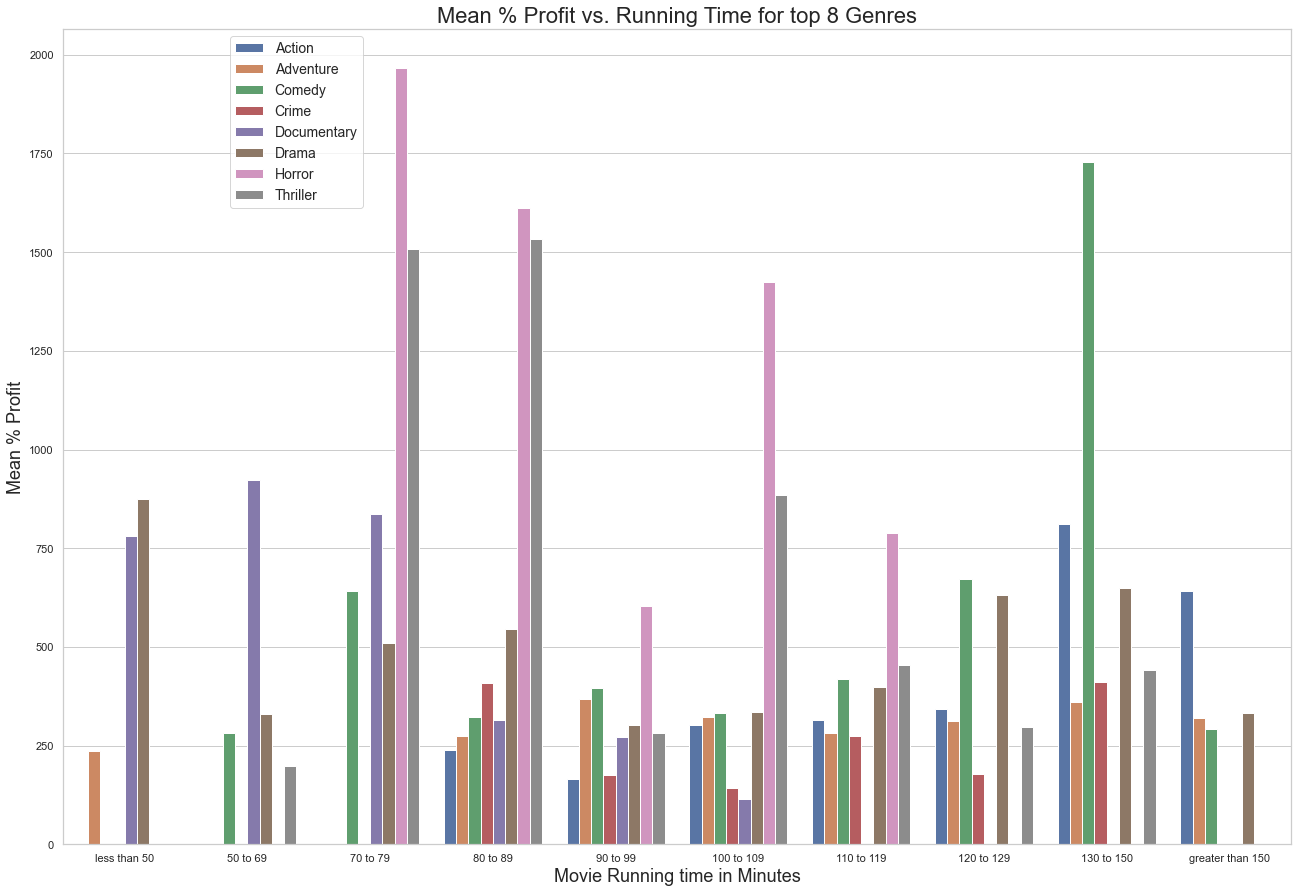

In [27]:
## Show Bar Plot Comparison to vividly depict most profitable running time for each genre. (For Mean % Profit)
ax2 = sns.barplot(x='runtime_minutes', y='% Profit', hue='genre',
                  order = ["less than 50", "50 to 69", "70 to 79", "80 to 89", "90 to 99", "100 to 109"
                     , "110 to 119", "120 to 129", "130 to 150", "greater than 150"],
                    data=runtime_df_agg)
sns.set(rc={'figure.figsize':(22,15), 'figure.facecolor':'white'})
sns.set_theme(style="whitegrid")
ax2.set_title("Mean % Profit vs. Running Time for top 8 Genres", size = 22)
ax2.set_xlabel("Movie Running time in Minutes", size = 18)
ax2.set_ylabel("Mean % Profit", size = 18);
ax2.legend(bbox_to_anchor= (0.13, 1), fontsize = 14);

## Save Image of this plot
plt.savefig('Runtime vs % Profit by Mean')

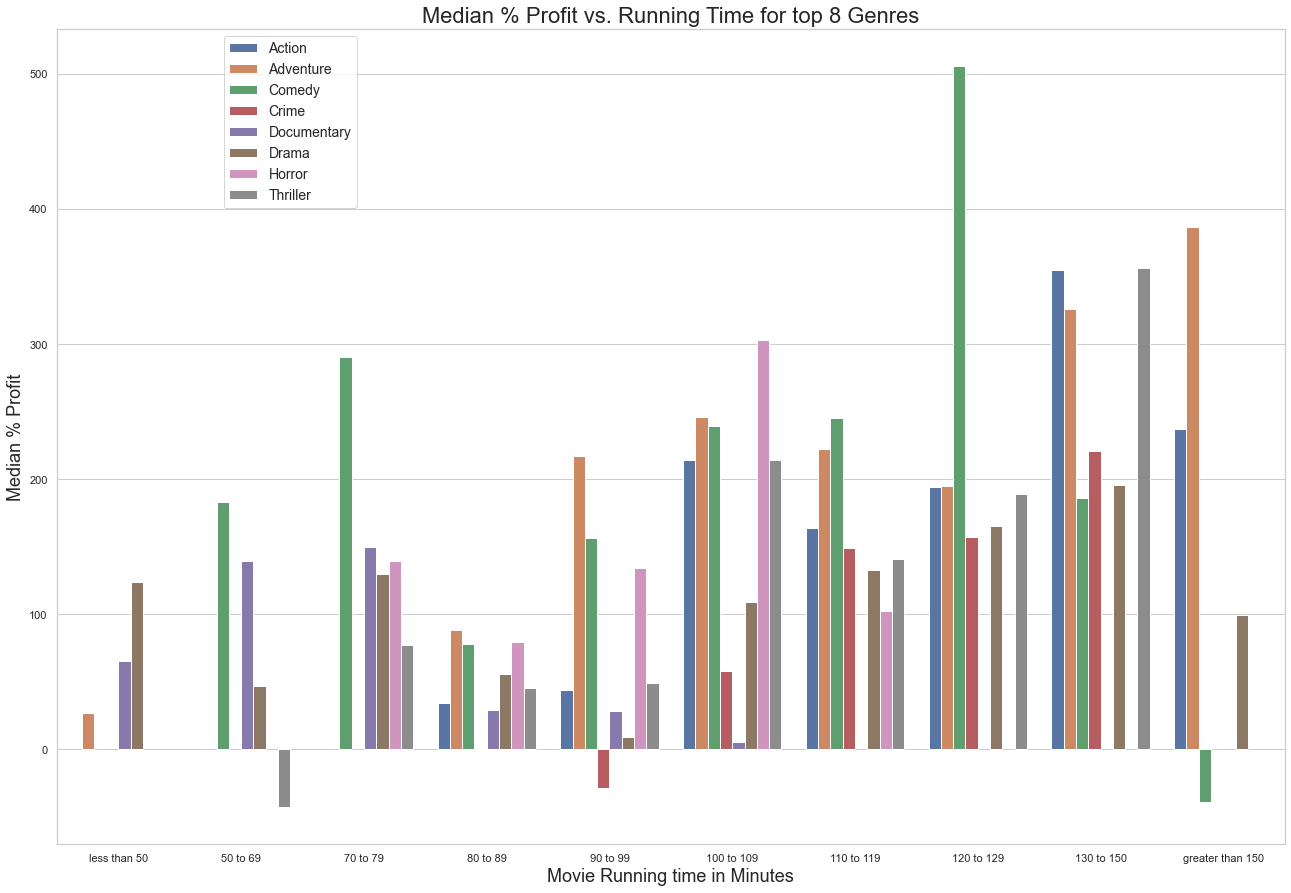

In [28]:
## Show Bar Plot Comparison to vividly depict most profitable running time for each genre. (For Median % Profit)
ax2 = sns.barplot(x='runtime_minutes', y='% Profit', hue='genre',
                  order = ["less than 50", "50 to 69", "70 to 79", "80 to 89", "90 to 99", "100 to 109"
                     , "110 to 119", "120 to 129", "130 to 150", "greater than 150"],
                    data=runtime_df_agg_med)
sns.set(rc={'figure.figsize':(22,15), 'figure.facecolor':'white'})
sns.set_theme(style="whitegrid")
ax2.set_title("Median % Profit vs. Running Time for top 8 Genres", size = 22)
ax2.set_xlabel("Movie Running time in Minutes", size = 18)
ax2.set_ylabel("Median % Profit", size = 18);
ax2.legend(bbox_to_anchor= (0.13, 1), fontsize = 14);

## Save Image of this plot
plt.savefig('Runtime vs % Profit by Median')

## Figure out best season to release for Adventure Genre
From the previous analysis, we came up with following:
1. Adventure Genre is the most profitable genre.
2. Adventure Genre with its running time greater than 150 minutes is most profitable genre.

Now... what would be the most profitalbe season to release Adventure Genre?

In [29]:
## Clean up Data to prepare for the analysis.
## Separate Genres separated by comma in genres column into other columns.
genres_1 = genres[["release_date","primary_title","production_budget","total_profit","genre1"]]
genres_1.columns = ["release_date","primary_title","production_budget","total_profit","genre1"]

genres_2 = genres[["release_date","primary_title","production_budget","total_profit","genre2"]]
genres_2.columns = ["release_date","primary_title","production_budget","total_profit","genre1"]

genres_3 = genres[["release_date","primary_title","production_budget","total_profit","genre3"]]
genres_3.columns = ["release_date","primary_title","production_budget","total_profit","genre1"]

In [30]:
## Concatenate genre1, genre2, genre3 column in to one single column.
release_season_df = pd.concat([genres_1, genres_2, genres_3], axis=0)
## Change column name genre1 to genre
release_season_df = release_season_df.rename(columns = {"genre1" : "genre"})
## Add Profit % Column
release_season_df["% Profit"] = release_season_df["total_profit"] / release_season_df["production_budget"] * 100
## Drop all the other genres other than Adventure
release_season_df = release_season_df[release_season_df.genre == "Adventure"]
## Extract Month from the release date.
release_season_df['Release_Month'] = release_season_df['release_date'].str[:3]

In [31]:
## Change Vlaues to Season instead of month.
for i, a in zip(release_season_df["Release_Month"], range(len(release_season_df)+1)):
    if i == "Sep" or i == "Oct" or i == "Nov":
        release_season_df["Release_Month"].iloc[a] = "Fall" 
    elif i == "Dec" or i == "Jan" or i == "Feb":
        release_season_df["Release_Month"].iloc[a] = "Winter"
    elif i == "Mar" or i == "Apr" or i == "May":
        release_season_df["Release_Month"].iloc[a] = "Spring"
    else:
        release_season_df["Release_Month"].iloc[a] = "Summer"

C:\Users\camla\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [32]:
## Rename Release_Month Column to Release_Season
release_season_df = release_season_df.rename(columns={"Release_Month": "Release_Season"})

In [33]:
release_season_df_mean = pd.pivot_table(release_season_df, values = ["% Profit"], index = ["Release_Season"],
                                aggfunc= {"% Profit": np.mean})

In [34]:
release_season_df_median = pd.pivot_table(release_season_df, values = ["% Profit"], index = ["Release_Season"],
                                aggfunc= {"% Profit": np.median})

In [35]:
## Reset index to make it easier to graph.
release_season_df_mean1 = release_season_df_mean.reset_index()
release_season_df_median1 = release_season_df_median.reset_index()

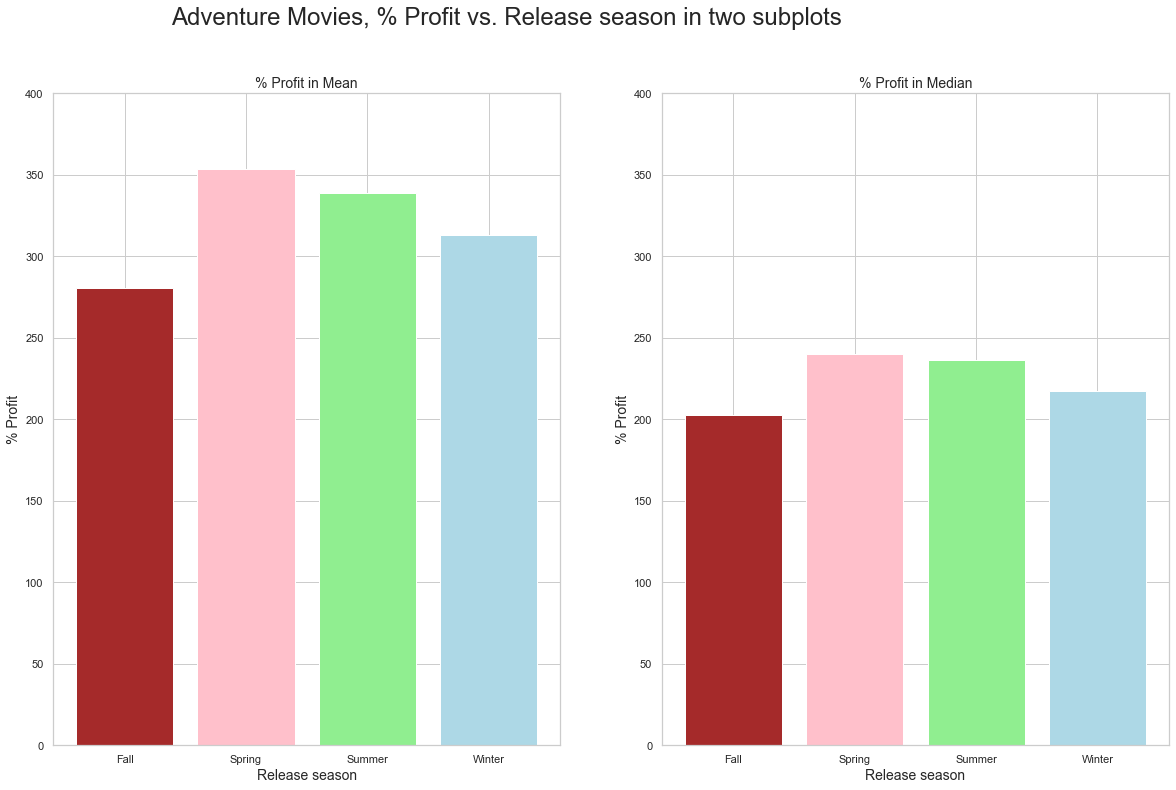

In [36]:
# Create the plot
fig, (ax1, ax2) = plt.subplots(figsize = (20,12), ncols =2)

# Set different limits of x and y axes for subplots
ax1.set_ylim(0, 400)
ax2.set_ylim(0, 400)


# Plot bar graphs of Mean % Profit and Median % Profit vs. Release Seasson
ax1.bar(release_season_df_mean1["Release_Season"] , release_season_df_mean1["% Profit"],
        color = ["brown", "pink", "lightgreen", "lightblue"])
ax2.bar(release_season_df_median1["Release_Season"] , release_season_df_median1["% Profit"],
        color = ["brown", "pink", "lightgreen", "lightblue"])

# Add a title to the figure
fig.suptitle("Adventure Movies, % Profit vs. Release season in two subplots", fontsize=24, x=0.44)

# Add title to each subplots
ax1.set_title("% Profit in Mean", size = 14)
ax2.set_title("% Profit in Median", size = 14)

# Add x label names for each subplot
ax1.set_xlabel("Release season", size = 14)
ax1.set_ylabel("% Profit", size = 14)

# Add x label names for each subplot
ax2.set_xlabel("Release season", size = 14)
ax2.set_ylabel("% Profit", size = 14);

## Save Image of this plot
plt.savefig('Most Profitable Release Season')